## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units=n, activation='relu', name='hidden_layer'+str(i))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n, activation='relu', name='hidden_layer'+str(i))(x)
            x = BatchNormalization()(x)
            
    output = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output])
            
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [5, 10, 25]

### ReduceLROnPlateau
- monitor: 被監測的資料。
- factor: 學習速率被降低的因數。新的學習速率 = 學習速率 * 因數
- patience: 沒有進步的訓練輪數，在這之後訓練速率會被降低。
- verbose: 整數。0：安靜，1：更新資訊。
- mode: {auto, min, max} 其中之一。如果是 min 模式，學習速率會被降低如果被監測的資料已經停止下降； 在 max 模式，學習塑膠會被降低如果被監測的資料已經停止上升； 在 auto 模式，方向會被從被監測的資料中自動推斷出來。
- min_delta: 對於測量新的最優化的閥值，只關注巨大的改變。
- cooldown: 在學習速率被降低之後，重新恢復正常操作之前等待的訓練輪數量。
- min_lr: 學習速率的下邊界。


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 8s 161us/step - loss: 1.2740 - acc: 0.5572 - val_loss: 1.4743 - val_acc: 0.4803
Epoch 14/25
50000/50000 [==============================] - 11s 217us/step - loss: 1.2520 - acc: 0.5654 - val_loss: 1.4664 - val_acc: 0.4868
Epoch 15/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2319 - acc: 0.5723 - val_loss: 1.4559 - val_acc: 0.4893
Epoch 16/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.2117 - acc: 0.5809 - val_loss: 1.4472 - val_acc: 0.4937
Epoch 17/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1920 - acc: 0.5867 - val_loss: 1.4506 - val_acc: 0.4898
Epoch 18/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.1734 - acc: 0.5961 - val_loss: 1.4384 - val_acc: 0.4957
Epoch 19/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.1558 - acc: 0.6006 - val_loss: 1.4430 - val_acc: 0.49221548 
Epoch 20/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 184us/step - loss: 2.2243 - acc: 0.2687 - val_loss: 2.1241 - val_acc: 0.3149
Epoch 2/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.7576 - acc: 0.3867 - val_loss: 1.8505 - val_acc: 0.3802
Epoch 3/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.6335 - acc: 0.4288 - val_loss: 1.7120 - val_acc: 0.4098
Epoch 4/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.5595 - acc: 0.4545 - val_loss: 1.6341 - val_acc: 0.4291
Epoch 5/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.5039 - acc: 0.4733 - val_loss: 1.5973 - val_acc: 0.4425
Epoch 6/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4588 - acc: 0.4888 - val_loss: 1.5703 - val_acc: 0.4513
Epoch 7/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4208 - acc: 0.5041 - val_loss: 1.5669 - 

50000/50000 [==============================] - 5s 109us/step - loss: 1.2497 - acc: 0.5681 - val_loss: 1.4927 - val_acc: 0.4775
Epoch 24/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2355 - acc: 0.5723 - val_loss: 1.4896 - val_acc: 0.4797
Epoch 25/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.2244 - acc: 0.5745 - val_loss: 1.4912 - val_acc: 0.4777
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_la

50000/50000 [==============================] - 5s 104us/step - loss: 1.4526 - acc: 0.4921 - val_loss: 1.5819 - val_acc: 0.4471
Epoch 11/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4316 - acc: 0.4991 - val_loss: 1.5750 - val_acc: 0.4460
Epoch 12/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4108 - acc: 0.5063 - val_loss: 1.5570 - val_acc: 0.4550
Epoch 13/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.3910 - acc: 0.5145 - val_loss: 1.5474 - val_acc: 0.4530
Epoch 14/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.3730 - acc: 0.5195 - val_loss: 1.5361 - val_acc: 0.4576
Epoch 15/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.3563 - acc: 0.5259 - val_loss: 1.5394 - val_acc: 0.4617
Epoch 16/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.3410 - acc: 0.5314 - val_loss: 1.5265 - val_acc: 0.4602
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.3758 - acc: 0.2247 - val_loss: 2.1927 - val_acc: 0.2801
Epoch 2/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.8893 - acc: 0.3480 - val_loss: 1.9499 - val_acc: 0.3429
Epoch 3/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.7526 - acc: 0.3902 - val_loss: 1.8041 - val_acc: 0.37741.7645 - acc: 0.386 - ETA: 0s - loss: 1.7640 - 
Epoch 4/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.6736 - acc: 0.4145 - val_loss: 1.7360 - val_acc: 0.3897
Epoch 5/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.6188 - acc: 0.4350 - val_loss: 1.6941 - val_acc: 0.4018
Epoch 6/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.5758 - acc: 0.4513 - val_loss: 1.6651 - val_acc: 0.4149
Epoch 7/25
50000/50000 [==============================] - 6s 112us/step - los

50000/50000 [==============================] - 6s 112us/step - loss: 0.7123 - acc: 0.7680 - val_loss: 1.3031 - val_acc: 0.5541

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 23/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.7094 - acc: 0.7702 - val_loss: 1.3034 - val_acc: 0.5549
Epoch 24/25
50000/50000 [==============================] - 7s 146us/step - loss: 0.7088 - acc: 0.7706 - val_loss: 1.3039 - val_acc: 0.5547
Epoch 25/25
50000/50000 [==============================] - 7s 144us/step - loss: 0.7092 - acc: 0.7708 - val_loss: 1.3043 - val_acc: 0.5553
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)          

Epoch 9/25
50000/50000 [==============================] - 6s 110us/step - loss: 2.2004 - acc: 0.2658 - val_loss: 2.2274 - val_acc: 0.2638
Epoch 10/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.1752 - acc: 0.2729 - val_loss: 2.2044 - val_acc: 0.2696
Epoch 11/25
50000/50000 [==============================] - 5s 109us/step - loss: 2.1534 - acc: 0.2778 - val_loss: 2.1831 - val_acc: 0.2746
Epoch 12/25
50000/50000 [==============================] - 5s 106us/step - loss: 2.1347 - acc: 0.2828 - val_loss: 2.1640 - val_acc: 0.2794
Epoch 13/25
50000/50000 [==============================] - 5s 108us/step - loss: 2.1176 - acc: 0.2877 - val_loss: 2.1470 - val_acc: 0.2822
Epoch 14/25
50000/50000 [==============================] - 5s 104us/step - loss: 2.1007 - acc: 0.2923 - val_loss: 2.1306 - val_acc: 0.2869
Epoch 15/25
50000/50000 [==============================] - 5s 109us/step - loss: 2.0865 - acc: 0.2951 - val_loss: 2.1154 - val_acc: 0.2899
Epoch 16/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 19s 380us/step - loss: 2.8076 - acc: 0.1399 - val_loss: 2.6331 - val_acc: 0.1744
Epoch 2/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.5517 - acc: 0.1858 - val_loss: 2.4986 - val_acc: 0.2041
Epoch 3/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.4370 - acc: 0.2096 - val_loss: 2.4176 - val_acc: 0.2200
Epoch 4/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.3643 - acc: 0.2265 - val_loss: 2.3576 - val_acc: 0.2308
Epoch 5/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.3113 - acc: 0.2390 - val_loss: 2.3122 - val_acc: 0.2410
Epoch 6/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.2704 - acc: 0.2497 - val_loss: 2.2743 - val_acc: 0.2518
Epoch 7/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.2374 - acc: 0.2578 - val_loss: 2.2424 -

Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.9815 - acc: 0.3270 - val_loss: 2.0162 - val_acc: 0.3111
Epoch 25/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.9747 - acc: 0.3291 - val_loss: 2.0087 - val_acc: 0.3138
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 6s 111us/step - loss: 2.1069 - acc: 0.2924 - val_loss: 2.1374 - val_acc: 0.2868
Epoch 12/25
50000/50000 [==============================] - 5s 108us/step - loss: 2.0883 - acc: 0.2968 - val_loss: 2.1221 - val_acc: 0.2887
Epoch 13/25
50000/50000 [==============================] - 5s 108us/step - loss: 2.0727 - acc: 0.3011 - val_loss: 2.1075 - val_acc: 0.2920
Epoch 14/25
50000/50000 [==============================] - 5s 107us/step - loss: 2.0584 - acc: 0.3064 - val_loss: 2.0943 - val_acc: 0.2964
Epoch 15/25
50000/50000 [==============================] - 5s 106us/step - loss: 2.0436 - acc: 0.3098 - val_loss: 2.0819 - val_acc: 0.2988
Epoch 16/25
50000/50000 [==============================] - 5s 107us/step - loss: 2.0321 - acc: 0.3132 - val_loss: 2.0709 - val_acc: 0.3022
Epoch 17/25
50000/50000 [==============================] - 5s 106us/step - loss: 2.0194 - acc: 0.3161 - val_loss: 2.0594 - val_acc: 0.3042
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 15s 306us/step - loss: 1.8366 - acc: 0.3673 - val_loss: 2.9763 - val_acc: 0.2129
Epoch 2/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.5386 - acc: 0.4533 - val_loss: 2.8517 - val_acc: 0.2573
Epoch 3/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4279 - acc: 0.4936 - val_loss: 1.9425 - val_acc: 0.3336
Epoch 4/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.3434 - acc: 0.5260 - val_loss: 2.0984 - val_acc: 0.3131
Epoch 5/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.2772 - acc: 0.5485 - val_loss: 1.9230 - val_acc: 0.3838
Epoch 6/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2210 - acc: 0.5679 - val_loss: 3.0793 - val_acc: 0.2217
Epoch 7/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.1723 - acc: 0.5849 - val_loss: 2.8020 -

50000/50000 [==============================] - 6s 118us/step - loss: 1.5236 - acc: 0.4725 - val_loss: 1.6527 - val_acc: 0.4274
Epoch 23/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.5118 - acc: 0.4744 - val_loss: 1.6458 - val_acc: 0.4272
Epoch 24/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.5016 - acc: 0.4766 - val_loss: 1.6348 - val_acc: 0.4304
Epoch 25/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4909 - acc: 0.4820 - val_loss: 1.6339 - val_acc: 0.4335
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)               786688    
_________________________________________________________________


50000/50000 [==============================] - 6s 118us/step - loss: 1.7601 - acc: 0.3882 - val_loss: 1.8170 - val_acc: 0.3711
Epoch 10/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.7322 - acc: 0.3976 - val_loss: 1.7927 - val_acc: 0.3767
Epoch 11/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.7065 - acc: 0.4059 - val_loss: 1.7696 - val_acc: 0.3876
Epoch 12/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.6842 - acc: 0.4152 - val_loss: 1.7508 - val_acc: 0.3928
Epoch 13/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.6627 - acc: 0.4214 - val_loss: 1.7361 - val_acc: 0.3912
Epoch 14/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.6430 - acc: 0.4278 - val_loss: 1.7211 - val_acc: 0.3984
Epoch 15/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.6243 - acc: 0.4351 - val_loss: 1.7101 - val_acc: 0.4028
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 268us/step - loss: 2.6350 - acc: 0.1609 - val_loss: 2.4530 - val_acc: 0.2143
Epoch 2/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.2818 - acc: 0.2390 - val_loss: 2.2364 - val_acc: 0.2595
Epoch 3/25
50000/50000 [==============================] - 5s 101us/step - loss: 2.1181 - acc: 0.2837 - val_loss: 2.1122 - val_acc: 0.2841
Epoch 4/25
50000/50000 [==============================] - 5s 106us/step - loss: 2.0149 - acc: 0.3120 - val_loss: 2.0415 - val_acc: 0.3103
Epoch 5/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.9409 - acc: 0.3329 - val_loss: 1.9714 - val_acc: 0.3281
Epoch 6/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8840 - acc: 0.3499 - val_loss: 1.9225 - val_acc: 0.3408
Epoch 7/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.8376 - acc: 0.3630 - val_loss: 1.8787 - 

50000/50000 [==============================] - 6s 120us/step - loss: 1.5197 - acc: 0.4718 - val_loss: 1.6595 - val_acc: 0.4213
Epoch 24/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5084 - acc: 0.4748 - val_loss: 1.6549 - val_acc: 0.4249
Epoch 25/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4976 - acc: 0.4806 - val_loss: 1.6442 - val_acc: 0.4273
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 6s 128us/step - loss: 1.7481 - acc: 0.3986 - val_loss: 1.8193 - val_acc: 0.3748
Epoch 11/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.7217 - acc: 0.4046 - val_loss: 1.7982 - val_acc: 0.3770
Epoch 12/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.6975 - acc: 0.4152 - val_loss: 1.7794 - val_acc: 0.3841
Epoch 13/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.6738 - acc: 0.4209 - val_loss: 1.7628 - val_acc: 0.3886
Epoch 14/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.6547 - acc: 0.4278 - val_loss: 1.7509 - val_acc: 0.3925
Epoch 15/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.6349 - acc: 0.4324 - val_loss: 1.7390 - val_acc: 0.3994
Epoch 16/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6191 - acc: 0.4400 - val_loss: 1.7192 - val_acc: 0.3994
Epoch 17/25
50000/50000 [==============

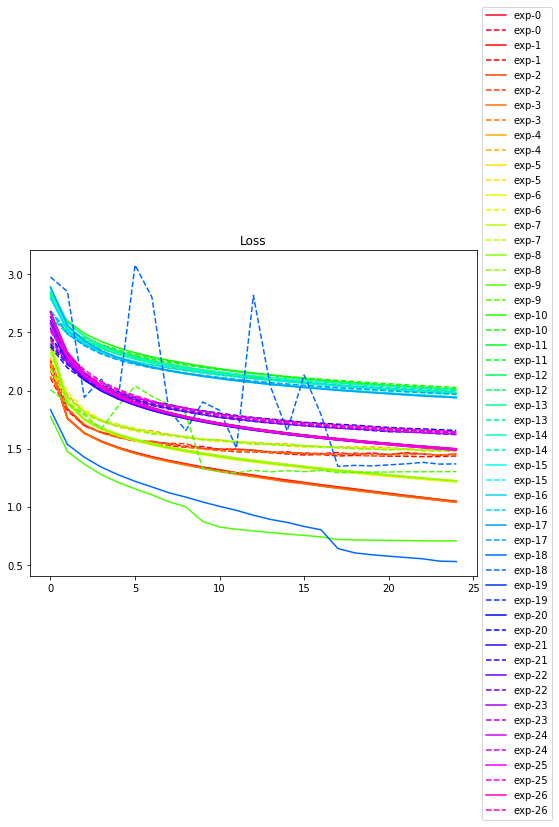

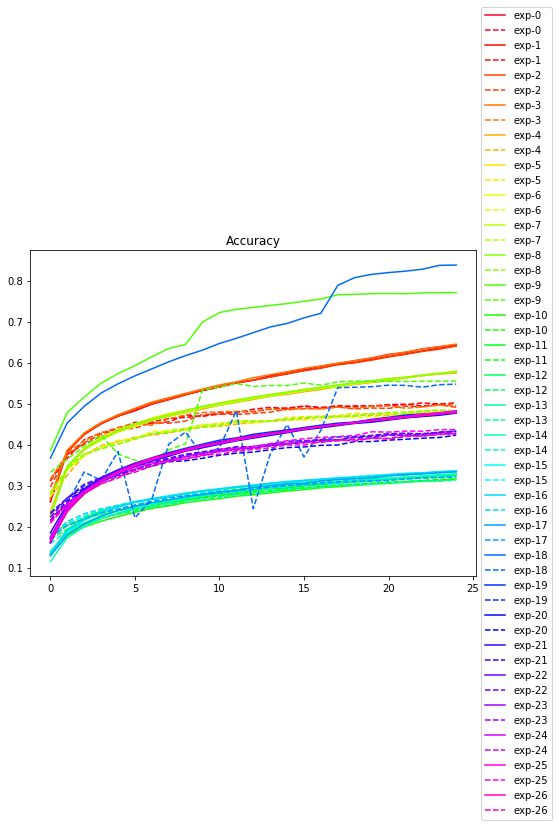

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### A. LearningRateScheduler

- 在每個 epoch 開始前，得到目前 lr
- 根據 schedule function 重新計算 lr，比如 epoch = n 時， new_lr = lr * 0.1
- 將 optimizer 的 lr 設定為 new_lr
- 根據 shhedule 函式，假設要自訂的話，它應該吃兩個參數：epoch & lr

### B. ReduceLR

- 在每個 epoch 結束時，得到目前監控目標的數值
- 如果目標比目前儲存的還要差的話，wait+1；若否則 wait 設為 0，目前監控數值更新新的數值
- 如果 wait >= patient，new_lr = lr * factor，將 optimizer 的 lr 設定為 new_lr，並且 wait 設回 0